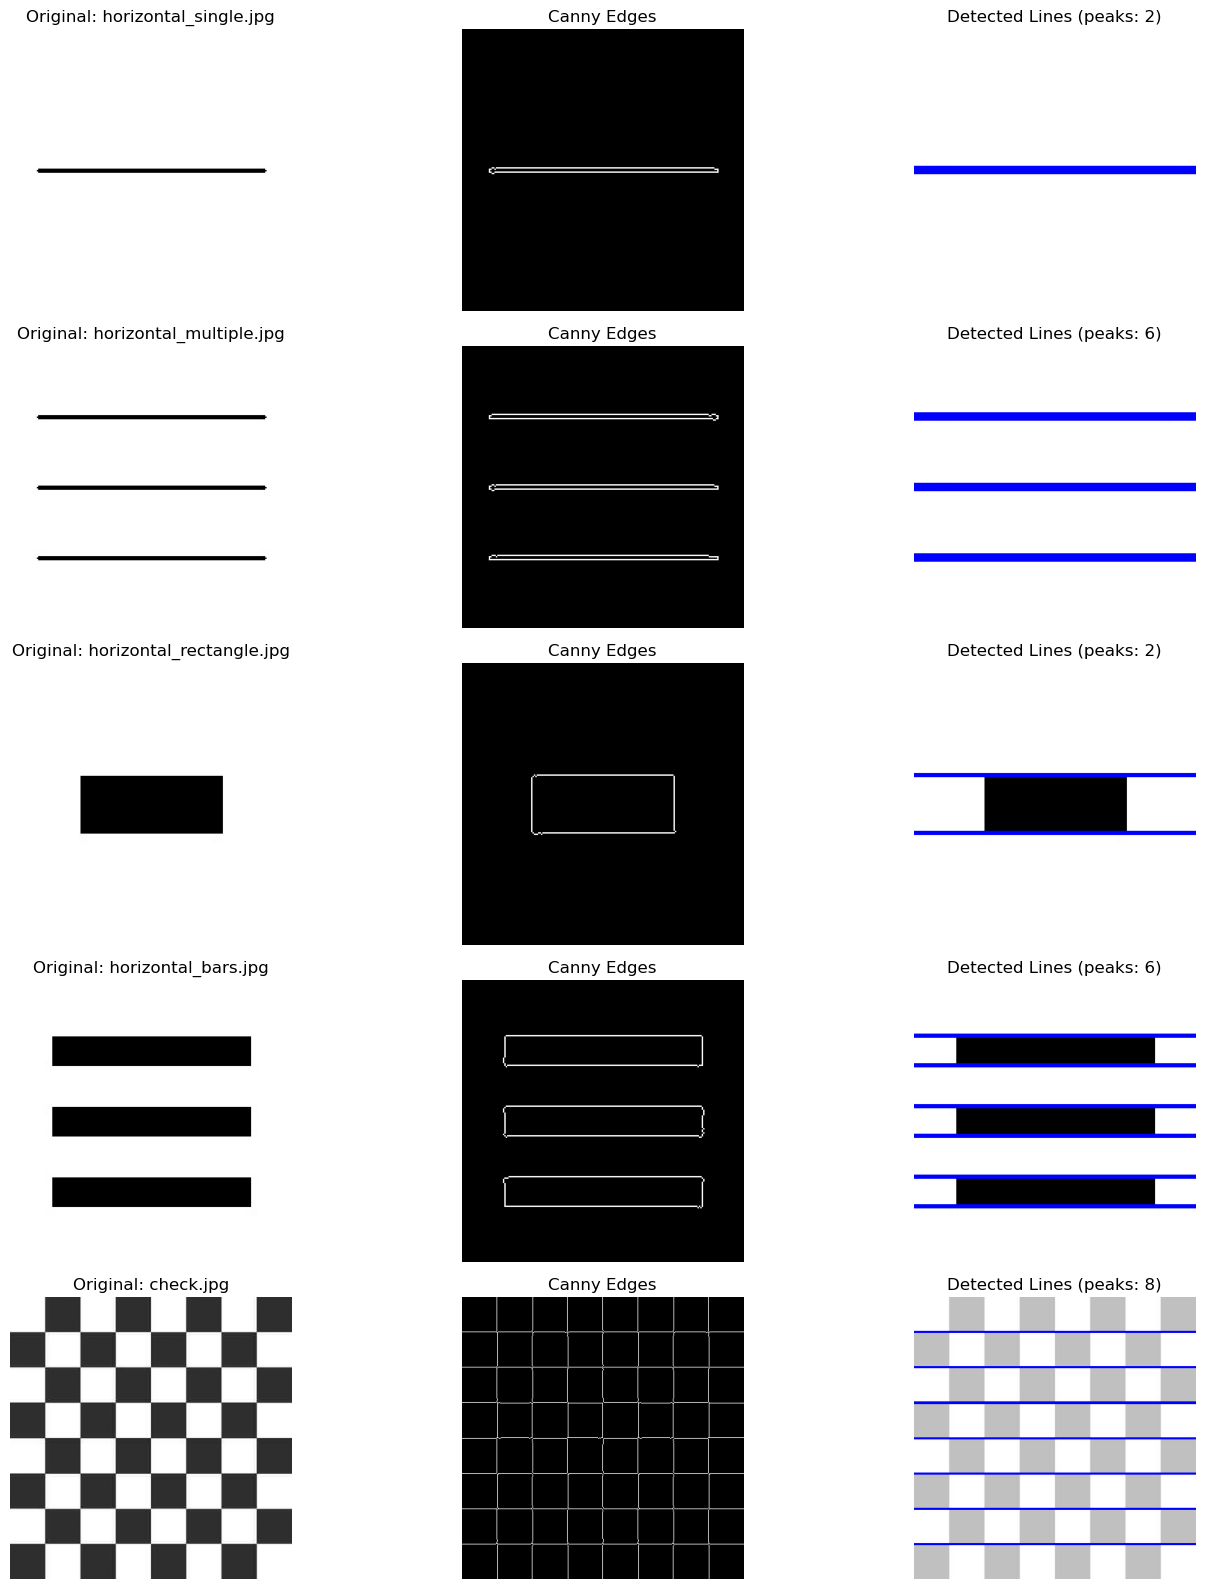

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage

test_images = [
    "horizontal_single.jpg",
    "horizontal_multiple.jpg", 
    "horizontal_rectangle.jpg",
    "horizontal_bars.jpg",
    "check.jpg"
]

def hough_transform(edges, m_step=1, c_step=1):
    h, w = edges.shape
    m_range = np.arange(-1.0, 1.0, m_step)
    c_range = np.arange(-h, h, c_step)
    accumulator = np.zeros((len(m_range), len(c_range)))
    y, x = np.nonzero(edges)
    for m_idx, m in enumerate(m_range):
        c = y - m * x
        for c_val in c:
            c_idx = int(round(c_val - c_range[0]))
            if 0 <= c_idx < len(c_range):
                accumulator[m_idx, c_idx] += 1
    return accumulator, m_range, c_range


 

def draw_lines(img, peaks, m_range, c_range):
    img_color = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    for peak in peaks:
        m_idx, c_idx = peak
        m = m_range[m_idx]
        c = c_range[c_idx]
        y0 = int(c)
        y1 = int(m * img.shape[1] + c)
        cv2.line(img_color, (0, y0), (img.shape[1], y1), (0, 0, 255), 2)
    return img_color

fig, axes = plt.subplots(5, 3, figsize=(15, 16))

for idx, img_path in enumerate(test_images):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    edges_cv = cv2.Canny(img, 50, 150)
    accumulator, m_range, c_range = hough_transform(edges_cv)
    peaks = np.argwhere(accumulator > np.max(accumulator) * 0.5)
    img_color = draw_lines(img, peaks, m_range, c_range)
    
    axes[idx, 0].imshow(img, cmap='gray')
    axes[idx, 0].set_title(f'Original: {img_path}')
    axes[idx, 0].axis('off')
    
    axes[idx, 1].imshow(edges_cv, cmap='gray')
    axes[idx, 1].set_title('Canny Edges')
    axes[idx, 1].axis('off')
    
    axes[idx, 2].imshow(img_color)
    axes[idx, 2].set_title(f'Detected Lines (peaks: {len(peaks)})')
    axes[idx, 2].axis('off')

plt.tight_layout()
plt.show()

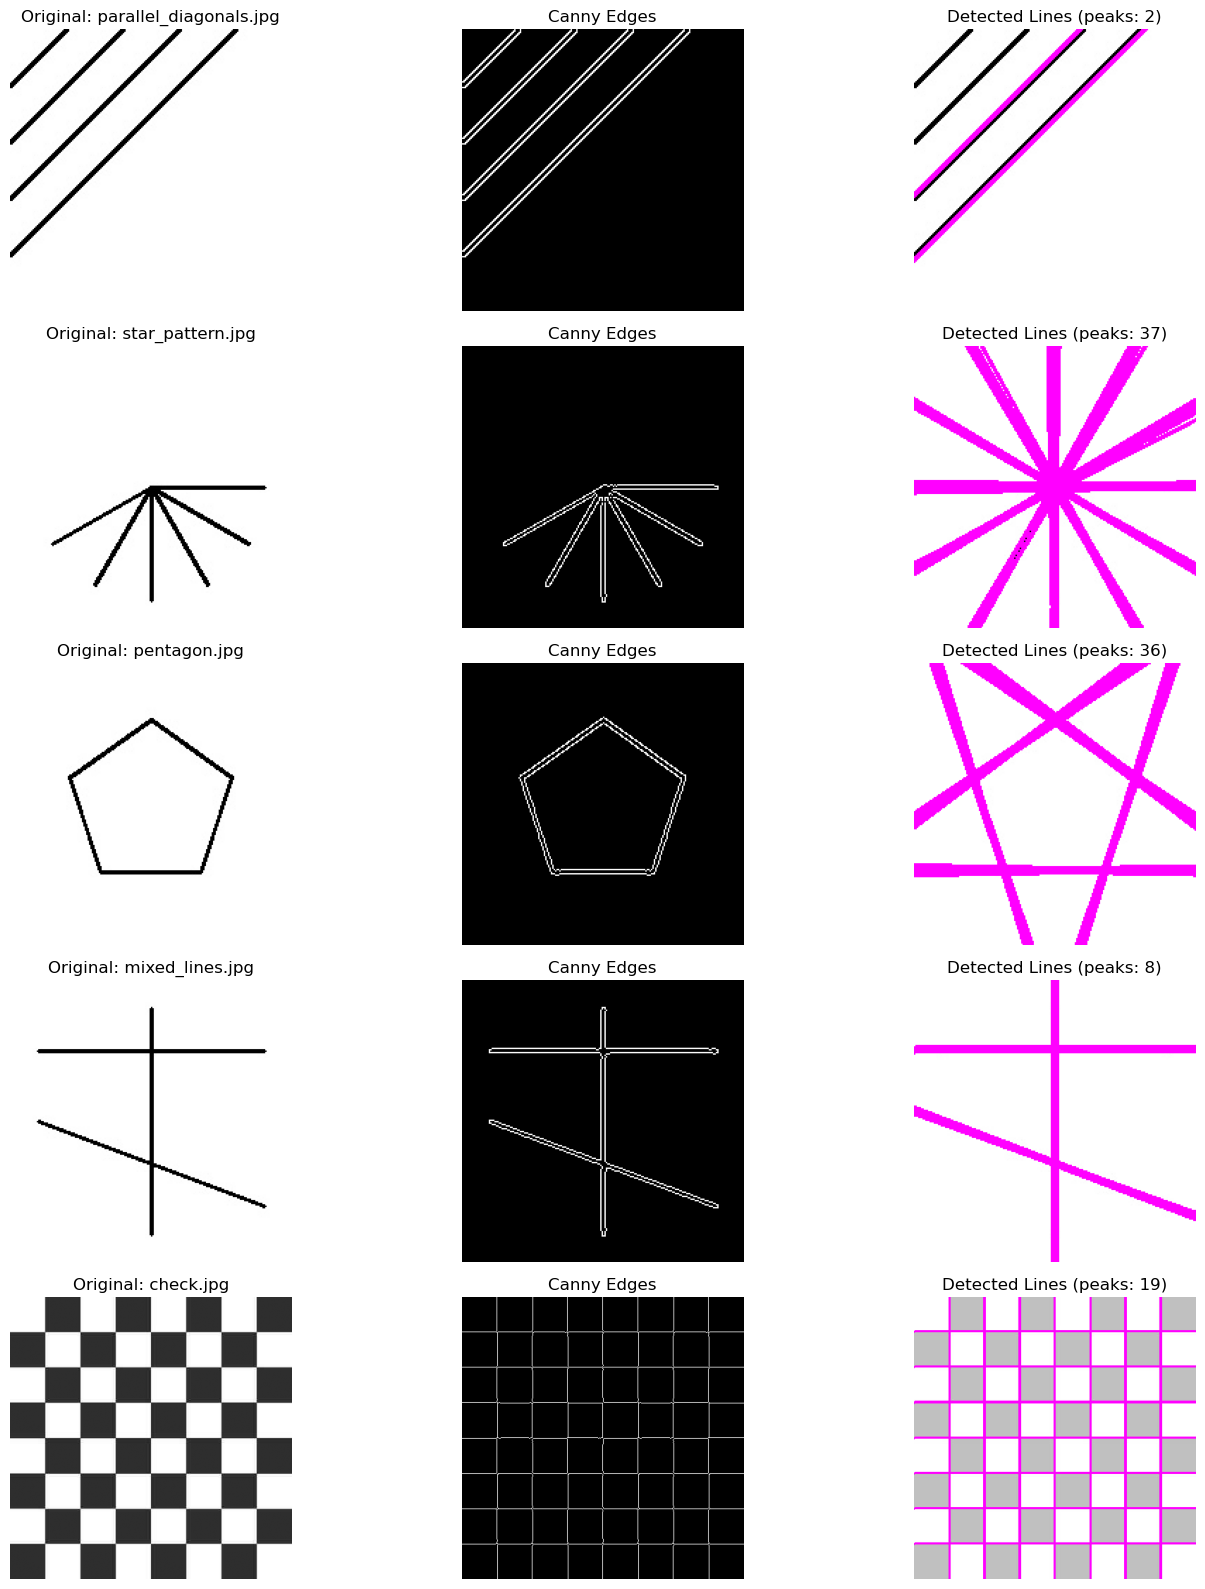

In [3]:

test_images = [
    "parallel_diagonals.jpg",
    "star_pattern.jpg",
    "pentagon.jpg",
    "mixed_lines.jpg",
    "check.jpg"
]

def hough_transform_polar(edges, theta_step=1, rho_step=1):
    h, w = edges.shape
    diagonal = int(np.sqrt(h**2 + w**2))
    rho_range = np.arange(-diagonal, diagonal + 1, rho_step)
    theta_range = np.deg2rad(np.arange(0, 180, theta_step))
    accumulator = np.zeros((len(rho_range), len(theta_range)))
    y, x = np.nonzero(edges)
    for i in range(len(x)):
        for theta_idx, theta in enumerate(theta_range):
            rho = x[i] * np.cos(theta) + y[i] * np.sin(theta)
            rho_idx = int(round(rho - rho_range[0]))
            if 0 <= rho_idx < len(rho_range):
                accumulator[rho_idx, theta_idx] += 1
    return accumulator, rho_range, theta_range

def draw_lines_polar(img, peaks, rho_range, theta_range):
    img_color = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    h, w = img.shape
    max_dist = max(h, w) * 2 
    for peak in peaks:
        rho_idx, theta_idx = peak
        rho = rho_range[rho_idx]
        theta = theta_range[theta_idx]
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a * rho
        y0 = b * rho
        x1 = int(x0 + max_dist * (-b))
        y1 = int(y0 + max_dist * (a))
        x2 = int(x0 - max_dist * (-b))
        y2 = int(y0 - max_dist * (a))
        cv2.line(img_color, (x1, y1), (x2, y2), (255, 0, 255), 2)
    return img_color

fig, axes = plt.subplots(5, 3, figsize=(15, 16))

for idx, img_path in enumerate(test_images):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    edges_cv = cv2.Canny(img, 50, 150)
    accumulator, rho_range, theta_range = hough_transform_polar(edges_cv)
    peaks = np.argwhere(accumulator > np.max(accumulator) * 0.5)
    img_color = draw_lines_polar(img, peaks, rho_range, theta_range)
    
    axes[idx, 0].imshow(img, cmap='gray')
    axes[idx, 0].set_title(f'Original: {img_path}')
    axes[idx, 0].axis('off')
    
    axes[idx, 1].imshow(edges_cv, cmap='gray')
    axes[idx, 1].set_title('Canny Edges')
    axes[idx, 1].axis('off')
    
    axes[idx, 2].imshow(img_color)
    axes[idx, 2].set_title(f'Detected Lines (peaks: {len(peaks)})')
    axes[idx, 2].axis('off')

plt.tight_layout()
plt.show()

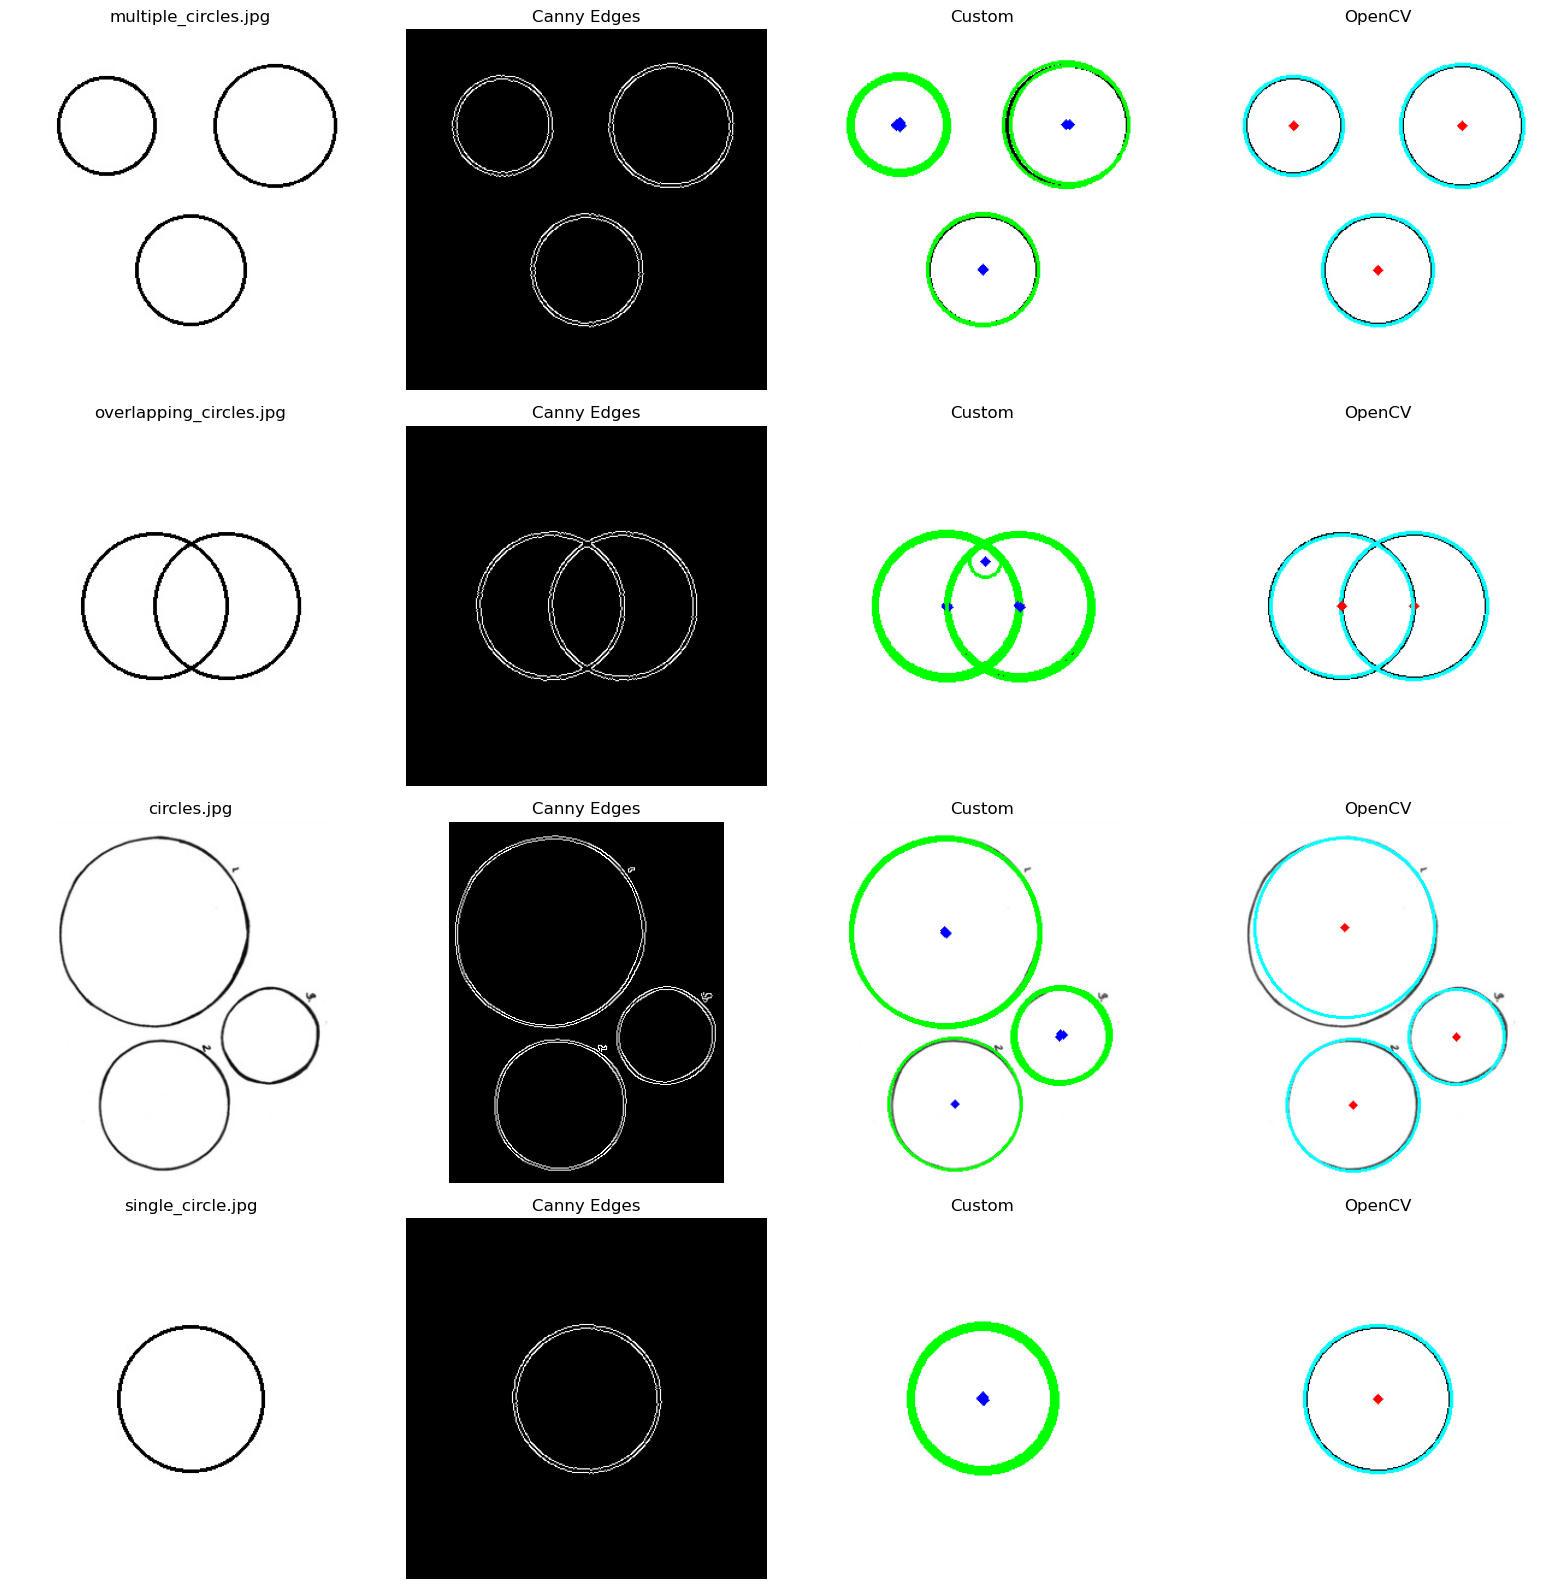

In [ ]:


def hough_circle_simple(edges, r_min=10, r_max=50, r_step=2):
    h, w = edges.shape
    r_range = np.arange(r_min, r_max, r_step)
    accumulator = np.zeros((h, w, len(r_range)))
    y, x = np.nonzero(edges)
    for xi, yi in zip(x, y):
        for r_idx, r in enumerate(r_range):
            for theta in np.linspace(0, 2*np.pi, 20):
                a = int(xi - r * np.cos(theta))
                b = int(yi - r * np.sin(theta))
                if 0 <= a < w and 0 <= b < h:
                    accumulator[b, a, r_idx] += 1
    return accumulator, r_range

def find_circles(accumulator, r_range, threshold_ratio=0.2):
    threshold = threshold_ratio * np.max(accumulator)
    peaks = np.argwhere(accumulator > threshold)
    circles = []
    for b, a, r_idx in peaks:
        r = r_range[r_idx]
        votes = accumulator[b, a, r_idx]
        circles.append((a, b, r, votes))
    circles = sorted(circles, key=lambda x: x[3], reverse=True)
    return circles[:10]

circle_images = ['multiple_circles.jpg', 'overlapping_circles.jpg', 'circles.jpg', 'single_circle.jpg']
fig, axes = plt.subplots(len(circle_images), 4, figsize=(16, 4*len(circle_images)))
if len(circle_images) == 1:
    axes = axes.reshape(1, -1)

for i, img_path in enumerate(circle_images):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    edges = cv2.Canny(img, 30, 100)
    acc, r_range = hough_circle_simple(edges, r_min=10, r_max=min(img.shape)//2, r_step=3)
    custom_circles = find_circles(acc, r_range, threshold_ratio=0.2)
    opencv_circles = cv2.HoughCircles(
        img, cv2.HOUGH_GRADIENT, dp=1, minDist=30,
        param1=50, param2=30, minRadius=10, maxRadius=min(img.shape)//3
    )
    if opencv_circles is not None:
        opencv_circles = np.round(opencv_circles[0, :]).astype("int").tolist()
    else:
        opencv_circles = []

    # Original
    axes[i, 0].imshow(img, cmap='gray')
    axes[i, 0].set_title(f"{img_path}")
    axes[i, 0].axis('off')
    # Edges
    axes[i, 1].imshow(edges, cmap='gray')
    axes[i, 1].set_title('Canny Edges')
    axes[i, 1].axis('off')
    # Custom detection
    img_custom = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    for a, b, r, _ in custom_circles:
        cv2.circle(img_custom, (int(a), int(b)), int(r), (0, 255, 0), 2)
        cv2.circle(img_custom, (int(a), int(b)), 2, (0, 0, 255), 3)
    axes[i, 2].imshow(img_custom)
    axes[i, 2].set_title('Custom')
    axes[i, 2].axis('off')
    # OpenCV detection
    img_opencv = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    for x, y, r in opencv_circles:
        cv2.circle(img_opencv, (x, y), r, (0, 255, 255), 2)
        cv2.circle(img_opencv, (x, y), 2, (255, 0, 0), 3)
    axes[i, 3].imshow(img_opencv)
    axes[i, 3].set_title('OpenCV')
    axes[i, 3].axis('off')

plt.tight_layout()
plt.show()
